In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def load_excel(excel_file, sheet_name=0):
    df = pd.read_excel(excel_file,sheet_name=sheet_name)
    result = []
    
    for index, row in df.iterrows():
        
        voltage_str = row.get('Voltage_measured', '')
        voltage_list = [float(v) for v in str(voltage_str).split(',') if v.strip()]
        
        entry = {
            'data': {
                'Voltage_measured': voltage_list,  
                'temp': row.get('temp', 0),        
                'time': pd.to_datetime(row.get('time', '1970-01-01'))
            }
        }
        result.append(entry)
    return result   


In [4]:
# Qin
def cov_charge(data):
    results = []
    for entry in data:
        V_data = entry['data'].get('Voltage_measured', [])
        V_data = [v for v in V_data if isinstance(v, (int, float))]
        
        if len(V_data) > 0:
            mean_voltage = sum(V_data) / len(V_data)
            std_voltage = (sum((x - mean_voltage)**2 for x in V_data) / len(V_data))**0.5
            std_to_mean_ratio = std_voltage / mean_voltage if mean_voltage != 0 else 0
            results.append({ 
                'mean_voltage': mean_voltage, 
                'std_voltage': std_voltage, 
                'std_to_mean_ratio': std_to_mean_ratio 
            })
        else:
            results.append({ 
                'mean_voltage': None, 
                'std_voltage': None, 
                'std_to_mean_ratio': None 
            })
    return results
def cov_charge(data):
    results = []
    for i, entry in enumerate(data):
        try:
            V_data = entry['data'].get('Voltage_measured', [])
            # 确保是浮点数
            V_data = [float(v) for v in V_data if isinstance(v, (int, float, str)) and str(v).strip() != '']
            
            if len(V_data) > 0:
                mean_voltage = np.mean(V_data)
                std_voltage = np.std(V_data)
                std_to_mean_ratio = std_voltage / mean_voltage if mean_voltage != 0 else 0
                results.append({
                    'mean_voltage': mean_voltage,
                    'std_voltage': std_voltage,
                    'std_to_mean_ratio': std_to_mean_ratio
                })
            else:
                results.append({
                    'mean_voltage': None,
                    'std_voltage': None,
                    'std_to_mean_ratio': None
                })
        except Exception as e:
            print(f"Error at entry {i}: {e}")
            results.append({
                'mean_voltage': None,
                'std_voltage': None,
                'std_to_mean_ratio': None
            })
    return results

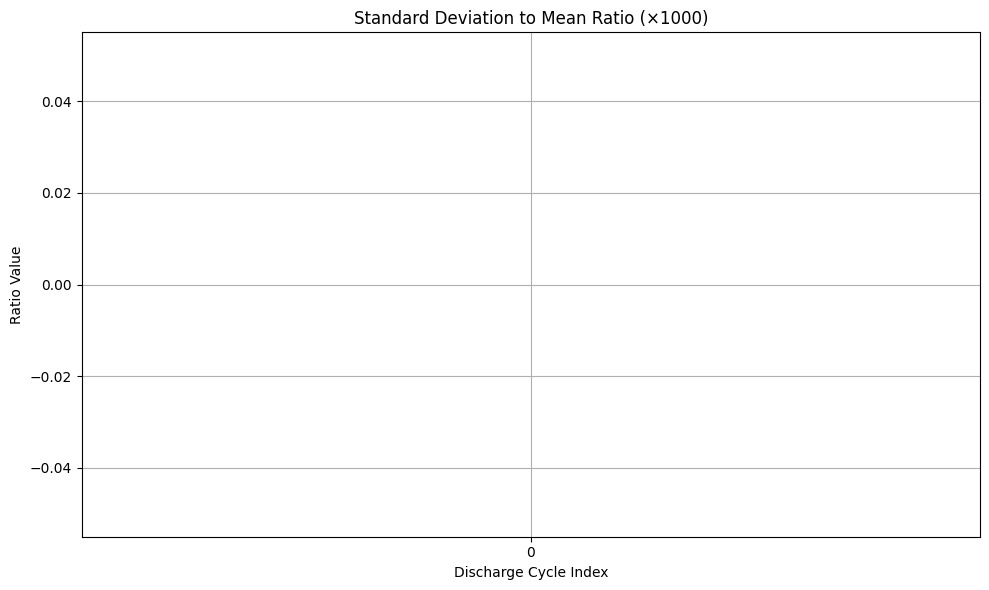

In [6]:
if __name__ == "__main__": 
    
    excel_path = '/home/newuser/Documents/Battery/Battery_data/battrey1.xlsx'  
    
    data = load_excel(excel_path)
    
    statistics = cov_charge(data)
    
    
    std_to_mean_ratios = [stat['std_to_mean_ratio']*1000 if stat['std_to_mean_ratio'] else None 
                         for stat in statistics]
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(std_to_mean_ratios, marker='o', linestyle='-', color='r')
    plt.title('Standard Deviation to Mean Ratio (×1000)')
    plt.xlabel('Discharge Cycle Index')
    plt.ylabel('Ratio Value')
    plt.grid(True)
    
    
    max_cycles = len(std_to_mean_ratios)
    plt.xticks(range(0, max_cycles, max(1, max_cycles//10)))
    
    plt.tight_layout()
    plt.show()

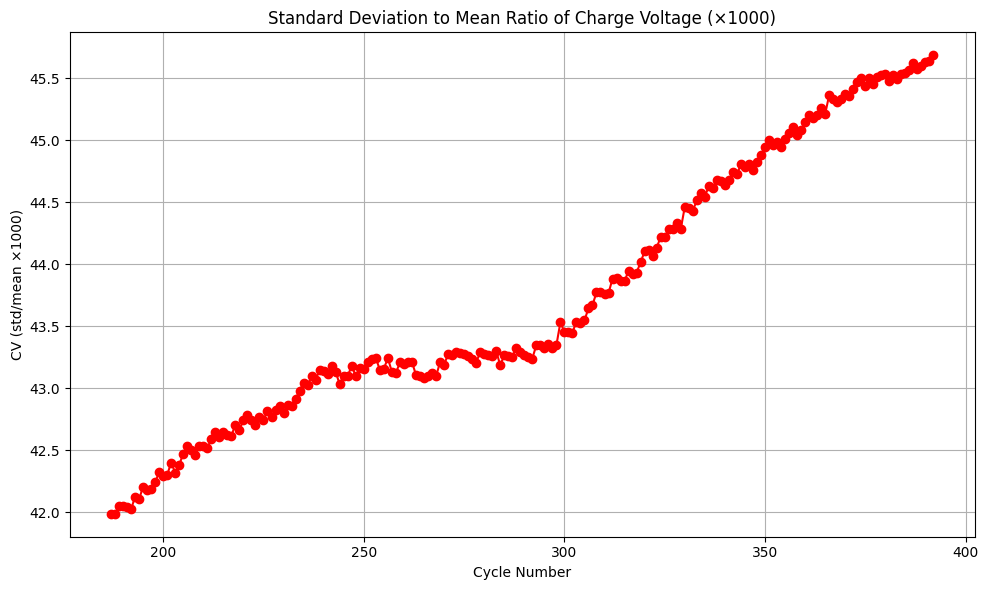

In [5]:
# 按照cyclde分组，在每个充电阶段，提取电压序列，计算CV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def cov_curve_from_dataframe(df):
    results = []

    # 只选充电状态数据（忽略 Discharge 和 Rest）
    # df_charge = df[df['State'].str.contains('Charge', case=False, na=False)]
    # 提取真正的充电状态（包含 Chg，但不含 DChg）
    df_charge = df[
        df['State'].str.contains('Chg', case=False, na=False) & 
        ~df['State'].str.contains('DChg', case=False, na=False)
    ]
    # 按 Cycle 分组
    grouped = df_charge.groupby('Cycle')

    for cycle, group in grouped:
        voltages = group['Voltage(V)'].dropna().values

        if len(voltages) > 0:
            mean_v = np.mean(voltages)
            std_v = np.std(voltages)
            ratio = std_v / mean_v if mean_v != 0 else 0
            results.append({
                'cycle': cycle,
                'mean_voltage': mean_v,
                'std_voltage': std_v,
                'std_to_mean_ratio': ratio
            })

    return results

# === 主程序 ===
if __name__ == "__main__":
    excel_path = '/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_1/LISHEN_LFP_1.0C-2.0D_T25_1-1.xlsx'
    df = pd.read_excel(excel_path, sheet_name='Detail_66_4_8')

    stats = cov_curve_from_dataframe(df)

    # 取出数据用于绘图
    cycles = [item['cycle'] for item in stats]
    ratios = [item['std_to_mean_ratio'] * 1000 for item in stats]  # 放大 ×1000

    plt.figure(figsize=(10, 6))
    plt.plot(cycles, ratios, marker='o', linestyle='-', color='r')
    plt.title('Standard Deviation to Mean Ratio of Charge Voltage (×1000)')
    plt.xlabel('Cycle Number')
    plt.ylabel('CV (std/mean ×1000)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

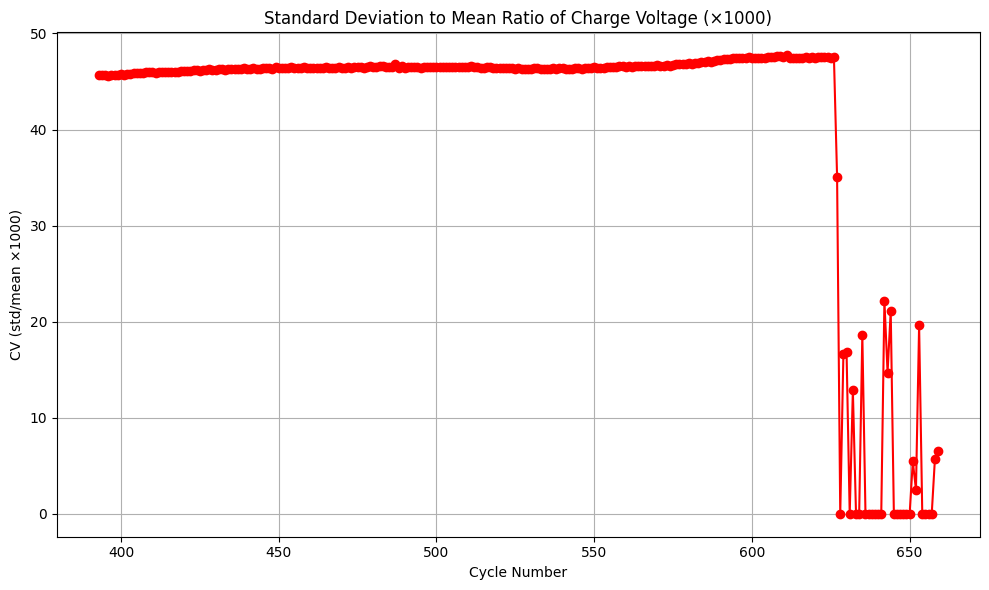

In [7]:
# 按照cyclde分组，在每个充电阶段，提取电压序列，计算CV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def cov_curve_from_dataframe(df):
    results = []

    # 只选充电状态数据（忽略 Discharge 和 Rest）
    # df_charge = df[df['State'].str.contains('Charge', case=False, na=False)]
    # 提取真正的充电状态（包含 Chg，但不含 DChg）
    df_charge = df[
        df['State'].str.contains('Chg', case=False, na=False) & 
        ~df['State'].str.contains('DChg', case=False, na=False)
    ]
    # 按 Cycle 分组
    grouped = df_charge.groupby('Cycle')

    for cycle, group in grouped:
        voltages = group['Voltage(V)'].dropna().values

        if len(voltages) > 0:
            mean_v = np.mean(voltages)
            std_v = np.std(voltages)
            ratio = std_v / mean_v if mean_v != 0 else 0
            results.append({
                'cycle': cycle,
                'mean_voltage': mean_v,
                'std_voltage': std_v,
                'std_to_mean_ratio': ratio
            })

    return results

# === 主程序 ===
if __name__ == "__main__":
    excel_path = '/home/newuser/Documents/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_1/LISHEN_LFP_1.0C-2.0D_T25_1-2.xlsx'
    df = pd.read_excel(excel_path, sheet_name='Detail_66_4_8')

    stats = cov_curve_from_dataframe(df)

    # 取出数据用于绘图
    cycles = [item['cycle'] for item in stats]
    ratios = [item['std_to_mean_ratio'] * 1000 for item in stats]  # 放大 ×1000

    plt.figure(figsize=(10, 6))
    plt.plot(cycles, ratios, marker='o', linestyle='-', color='r')
    plt.title('Standard Deviation to Mean Ratio of Charge Voltage (×1000)')
    plt.xlabel('Cycle Number')
    plt.ylabel('CV (std/mean ×1000)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [4]:
print(df['State'].unique())

['CCCV DChg' 'Rest' 'CCCV Chg']


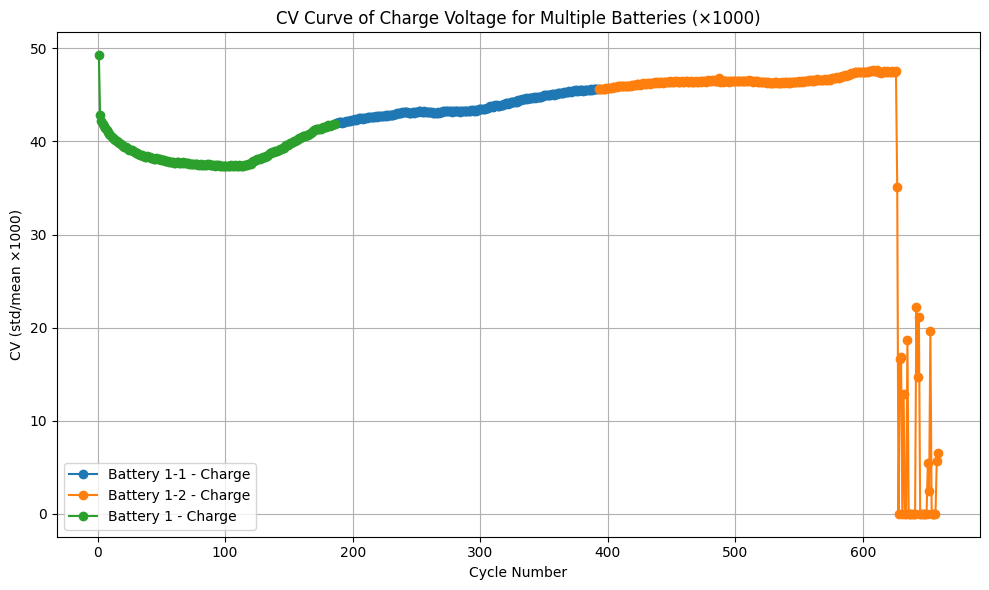

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_cv_by_state(df, state_filter):
    df_filtered = df[df['State'].str.contains(state_filter, case=False, na=False)]
    grouped = df_filtered.groupby('Cycle')

    results = []
    for cycle, group in grouped:
        voltages = group['Voltage(V)'].dropna().values
        if len(voltages) > 0:
            mean_v = np.mean(voltages)
            std_v = np.std(voltages)
            ratio = std_v / mean_v if mean_v != 0 else 0
            results.append({
                'cycle': cycle,
                'std_to_mean_ratio': ratio
            })
    return results

# Excel 文件路径及电池名映射
battery_files = {
    "Battery 1-1": "/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_1/LISHEN_LFP_1.0C-2.0D_T25_1-1.xlsx",
    "Battery 1-2": "/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_1/LISHEN_LFP_1.0C-2.0D_T25_1-2.xlsx",
    "Battery 1": "/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_1/LISHEN_LFP_1.0C-2.0D_T25_1.xlsx"
}

sheet_name = "Detail_66_4_8"

# 初始化绘图
plt.figure(figsize=(10, 6))

for battery_name, file_path in battery_files.items():
    df = pd.read_excel(file_path, sheet_name=sheet_name)

    # 充电阶段数据
    df_charge = df[
        df['State'].str.contains('Chg', case=False, na=False) &
        ~df['State'].str.contains('DChg', case=False, na=False)
    ]
    charge_stats = compute_cv_by_state(df_charge, 'Chg')
    cycles = [s['cycle'] for s in charge_stats]
    cv_vals = [s['std_to_mean_ratio'] * 1000 for s in charge_stats]

    # 绘图
    plt.plot(cycles, cv_vals, label=f"{battery_name} - Charge", marker='o')

    # （可选）放电阶段数据
    # df_dchg = df[df['State'].str.contains('DChg', case=False, na=False)]
    # dchg_stats = compute_cv_by_state(df_dchg, 'DChg')
    # cycles_dchg = [s['cycle'] for s in dchg_stats]
    # cv_dchg = [s['std_to_mean_ratio'] * 1000 for s in dchg_stats]
    # plt.plot(cycles_dchg, cv_dchg, linestyle='--', label=f"{battery_name} - Discharge")

# 图例 & 格式
plt.title("CV Curve of Charge Voltage for Multiple Batteries (×1000)")
plt.xlabel("Cycle Number")
plt.ylabel("CV (std/mean ×1000)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Processing Battery 1-1...
Processing Battery 1-2...
Processing Battery 1...


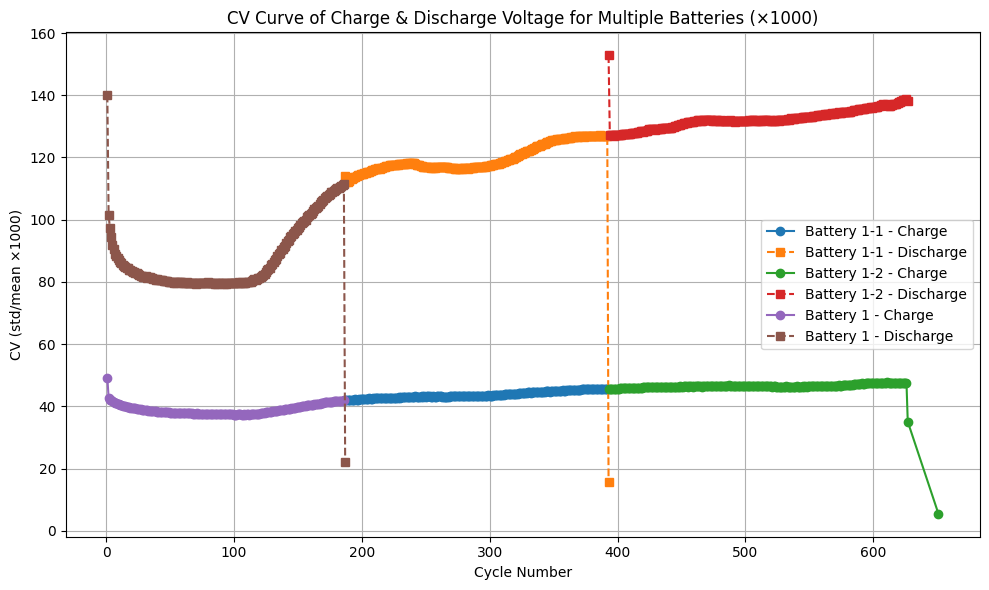

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 核心函数：根据状态筛选并计算每个Cycle的CV
def compute_cv_by_state(df, state_filter):
    df_filtered = df[df['State'].str.contains(state_filter, case=False, na=False)]
    grouped = df_filtered.groupby('Cycle')

    results = []
    for cycle, group in grouped:
        voltages = group['Voltage(V)'].dropna().values
        if len(voltages) < 3:
            continue  # 太少不可靠
        mean_v = np.mean(voltages)
        if mean_v == 0:
            continue  # 避免除以零
        std_v = np.std(voltages)
        ratio = std_v / mean_v
        results.append({
            'cycle': cycle,
            'std_to_mean_ratio': ratio
        })
    return results

# Excel 文件路径及电池名映射
battery_files = {
    "Battery 1-1": "/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_1/LISHEN_LFP_1.0C-2.0D_T25_1-1.xlsx",
    "Battery 1-2": "/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_1/LISHEN_LFP_1.0C-2.0D_T25_1-2.xlsx",
    "Battery 1":   "/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_1/LISHEN_LFP_1.0C-2.0D_T25_1.xlsx"
}

sheet_name = "Detail_66_4_8"

plt.figure(figsize=(10, 6))

for battery_name, file_path in battery_files.items():
    print(f"Processing {battery_name}...")

    df = pd.read_excel(file_path, sheet_name=sheet_name)

    # 充电阶段：包含 'Chg' 且不含 'DChg'
    df_charge = df[
        df['State'].str.contains('Chg', case=False, na=False) &
        ~df['State'].str.contains('DChg', case=False, na=False)
    ]
    charge_stats = compute_cv_by_state(df_charge, 'Chg')
    # 绘制全部循环
    # cycles_charge = [s['cycle'] for s in charge_stats]
    # cv_charge = [s['std_to_mean_ratio'] * 1000 for s in charge_stats]
    # 仅绘制前30个循环
    cycles_charge = [s['cycle'] for s in charge_stats if s['cycle'] <= 30]
    cv_charge = [s['std_to_mean_ratio'] * 1000 for s in charge_stats if s['cycle'] <= 30]

    plt.plot(cycles_charge, cv_charge, marker='o', linestyle='-', label=f"{battery_name} - Charge")

    # 放电阶段：包含 'DChg'
    df_dchg = df[df['State'].str.contains('DChg', case=False, na=False)]
    dchg_stats = compute_cv_by_state(df_dchg, 'DChg')
    # 绘制全部循环 
    cycles_dchg = [s['cycle'] for s in dchg_stats]
    cv_dchg = [s['std_to_mean_ratio'] * 1000 for s in dchg_stats]
    # 仅绘制前30个循环
    cycles_dchg = [s['cycle'] for s in dchg_stats if s['cycle'] <= 30]
    cv_dchg = [s['std_to_mean_ratio'] * 1000 for s in dchg_stats if s['cycle'] <= 30]
    plt.plot(cycles_dchg, cv_dchg, marker='s', linestyle='--', label=f"{battery_name} - Discharge")

# 图形设置
plt.title("CV Curve of Charge & Discharge Voltage for Multiple Batteries (×1000)")
plt.xlabel("Cycle Number")
plt.ylabel("CV (std/mean ×1000)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Processing Battery 1-1...
Processing Battery 1-2...
Processing Battery 1...


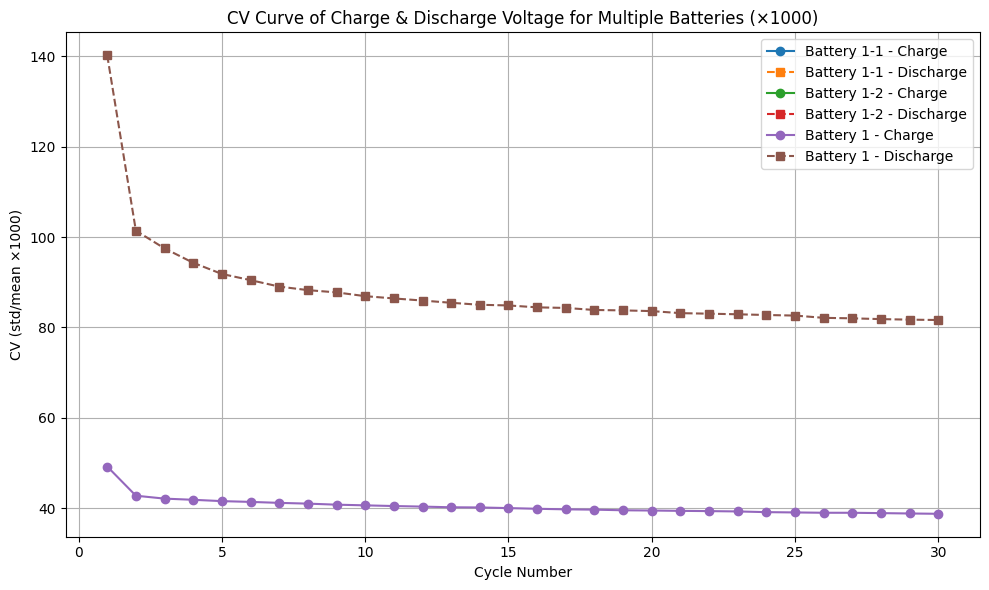

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 核心函数：根据状态筛选并计算每个Cycle的CV
def compute_cv_by_state(df, state_filter):
    df_filtered = df[df['State'].str.contains(state_filter, case=False, na=False)]
    grouped = df_filtered.groupby('Cycle')

    results = []
    for cycle, group in grouped:
        voltages = group['Voltage(V)'].dropna().values
        if len(voltages) < 3:
            continue  # 太少不可靠
        mean_v = np.mean(voltages)
        if mean_v == 0:
            continue  # 避免除以零
        std_v = np.std(voltages)
        ratio = std_v / mean_v
        results.append({
            'cycle': cycle,
            'std_to_mean_ratio': ratio
        })
    return results

# Excel 文件路径及电池名映射
battery_files = {
    "Battery 1-1": "/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_1/LISHEN_LFP_1.0C-2.0D_T25_1-1.xlsx",
    "Battery 1-2": "/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_1/LISHEN_LFP_1.0C-2.0D_T25_1-2.xlsx",
    "Battery 1":   "/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_1/LISHEN_LFP_1.0C-2.0D_T25_1.xlsx"
}

sheet_name = "Detail_66_4_8"

plt.figure(figsize=(10, 6))

for battery_name, file_path in battery_files.items():
    print(f"Processing {battery_name}...")

    df = pd.read_excel(file_path, sheet_name=sheet_name)

    # 充电阶段：包含 'Chg' 且不含 'DChg'
    df_charge = df[
        df['State'].str.contains('Chg', case=False, na=False) &
        ~df['State'].str.contains('DChg', case=False, na=False)
    ]
    charge_stats = compute_cv_by_state(df_charge, 'Chg')
    # 绘制全部循环
    # cycles_charge = [s['cycle'] for s in charge_stats]
    # cv_charge = [s['std_to_mean_ratio'] * 1000 for s in charge_stats]
    # 仅绘制前30个循环
    cycles_charge = [s['cycle'] for s in charge_stats if s['cycle'] <= 30]
    cv_charge = [s['std_to_mean_ratio'] * 1000 for s in charge_stats if s['cycle'] <= 30]

    plt.plot(cycles_charge, cv_charge, marker='o', linestyle='-', label=f"{battery_name} - Charge")

    # 放电阶段：包含 'DChg'
    df_dchg = df[df['State'].str.contains('DChg', case=False, na=False)]
    dchg_stats = compute_cv_by_state(df_dchg, 'DChg')
    # 绘制全部循环 
    # cycles_dchg = [s['cycle'] for s in dchg_stats]
    # cv_dchg = [s['std_to_mean_ratio'] * 1000 for s in dchg_stats]
    # 仅绘制前30个循环
    cycles_dchg = [s['cycle'] for s in dchg_stats if s['cycle'] <= 30]
    cv_dchg = [s['std_to_mean_ratio'] * 1000 for s in dchg_stats if s['cycle'] <= 30]
    plt.plot(cycles_dchg, cv_dchg, marker='s', linestyle='--', label=f"{battery_name} - Discharge")

# 图形设置
plt.title("CV Curve of Charge & Discharge Voltage for Multiple Batteries (×1000)")
plt.xlabel("Cycle Number")
plt.ylabel("CV (std/mean ×1000)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Processing Battery 1-1...
Processing Battery 1-2...
Processing Battery 1...


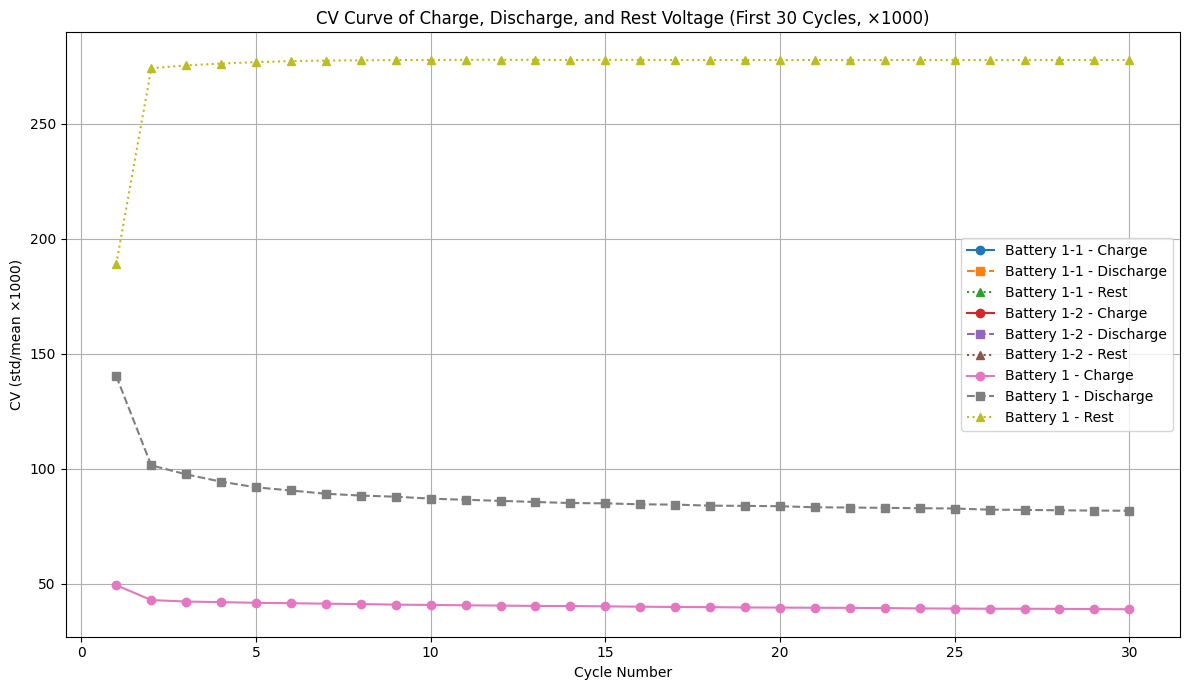

In [2]:
# 绘制前30个循环中，充电、放电和静置状态的CV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 通用函数：根据状态关键词计算每个Cycle的CV
def compute_cv_by_state(df, state_filter):
    df_filtered = df[df['State'].str.contains(state_filter, case=False, na=False)]
    grouped = df_filtered.groupby('Cycle')

    results = []
    for cycle, group in grouped:
        voltages = group['Voltage(V)'].dropna().values
        if len(voltages) < 3:
            continue  # 数据太少不可靠
        mean_v = np.mean(voltages)
        if mean_v == 0:
            continue  # 避免除以零
        std_v = np.std(voltages)
        ratio = std_v / mean_v
        results.append({
            'cycle': cycle,
            'std_to_mean_ratio': ratio
        })
    return results

# Excel 文件路径及电池名映射
battery_files = {
    "Battery 1-1": "/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_1/LISHEN_LFP_1.0C-2.0D_T25_1-1.xlsx",
    "Battery 1-2": "/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_1/LISHEN_LFP_1.0C-2.0D_T25_1-2.xlsx",
    "Battery 1":   "/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_1/LISHEN_LFP_1.0C-2.0D_T25_1.xlsx"
}

sheet_name = "Detail_66_4_8"

plt.figure(figsize=(12, 7))

for battery_name, file_path in battery_files.items():
    print(f"Processing {battery_name}...")

    df = pd.read_excel(file_path, sheet_name=sheet_name)

    # 充电阶段：'Chg' 但不是 'DChg'
    df_charge = df[df['State'].str.contains('Chg', case=False, na=False) & ~df['State'].str.contains('DChg', case=False, na=False)]
    charge_stats = compute_cv_by_state(df_charge, 'Chg')
    cycles_charge = [s['cycle'] for s in charge_stats if s['cycle'] <= 30]
    cv_charge = [s['std_to_mean_ratio'] * 1000 for s in charge_stats if s['cycle'] <= 30]
    plt.plot(cycles_charge, cv_charge, marker='o', linestyle='-', label=f"{battery_name} - Charge")

    # 放电阶段：'DChg'
    df_dchg = df[df['State'].str.contains('DChg', case=False, na=False)]
    dchg_stats = compute_cv_by_state(df_dchg, 'DChg')
    cycles_dchg = [s['cycle'] for s in dchg_stats if s['cycle'] <= 30]
    cv_dchg = [s['std_to_mean_ratio'] * 1000 for s in dchg_stats if s['cycle'] <= 30]
    plt.plot(cycles_dchg, cv_dchg, marker='s', linestyle='--', label=f"{battery_name} - Discharge")

    # 静置阶段：'Rest'
    df_rest = df[df['State'].str.contains('Rest', case=False, na=False)]
    rest_stats = compute_cv_by_state(df_rest, 'Rest')
    cycles_rest = [s['cycle'] for s in rest_stats if s['cycle'] <= 30]
    cv_rest = [s['std_to_mean_ratio'] * 1000 for s in rest_stats if s['cycle'] <= 30]
    plt.plot(cycles_rest, cv_rest, marker='^', linestyle=':', label=f"{battery_name} - Rest")

# 图形设置
plt.title("CV Curve of Charge, Discharge, and Rest Voltage (First 30 Cycles, ×1000)")
plt.xlabel("Cycle Number")
plt.ylabel("CV (std/mean ×1000)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import os

# 创建图像输出文件夹
os.makedirs("cv_plots", exist_ok=True)

# === 核心函数：根据状态计算每个 Cycle 的 CV ===
def compute_cv_by_state(df, state_filter):
    df_filtered = df[df['State'].str.contains(state_filter, case=False, na=False)]
    grouped = df_filtered.groupby('Cycle')

    results = []
    for cycle, group in grouped:
        voltages = group['Voltage(V)'].dropna().values
        if len(voltages) < 3:
            continue
        mean_v = np.mean(voltages)
        if mean_v == 0:
            continue
        std_v = np.std(voltages)
        ratio = std_v / mean_v
        results.append({
            'cycle': cycle,
            'std_to_mean_ratio': ratio
        })
    return results

# === 电池数据路径 ===
battery_files = {
    "Battery 1": "/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_1/LISHEN_LFP_1.0C-2.0D_T25_1.xlsx",
    "Battery 2": "/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_2/LISHEN_LFP_1.0C-2.0D_T25_2.xlsx",
    "Battery 3": "/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_3/LISHEN_LFP_1.0C-2.0D_T25_3.xlsx",
    "Battery 4": "/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_4/LISHEN_LFP_1.0C-2.0D_T25_4.xlsx",
    "Battery 5": "/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_5/LISHEN_LFP_1.0C-2.0D_T25_5.xlsx",
    "Battery 6": "/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_6/LISHEN_LFP_1.0C-2.0D_T25_6.xlsx",
    "Battery 7": "/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_7/LISHEN_LFP_1.0C-2.0D_T25_7.xlsx",
    "Battery 8": "/home/newuser/Documents/NDP/Battery/Battery_data/LISHEN/LISHEN_LFP_1.0C-2.0D_T25_8/LISHEN_LFP_1.0C-2.0D_T25_8.xlsx"
}

cv_summary_list = []

# === 主循环 ===
for battery_name, file_path in battery_files.items():
    print(f"Processing {battery_name}...")

    # 延迟读取 sheet，指定只需要的列
    xls = pd.ExcelFile(file_path)
    sheet = xls.sheet_names[2]  # 第三个工作表
    df = pd.read_excel(xls, sheet_name=sheet, usecols=['Cycle', 'State', 'Voltage(V)'])

    # 按状态筛选
    df_charge = df[df['State'].str.contains('Chg', case=False, na=False) & ~df['State'].str.contains('DChg', case=False, na=False)]
    df_dchg = df[df['State'].str.contains('DChg', case=False, na=False)]
    df_rest = df[df['State'].str.contains('Rest', case=False, na=False)]

    # 计算 CV
    charge_stats = compute_cv_by_state(df_charge, 'Chg')
    dchg_stats = compute_cv_by_state(df_dchg, 'DChg')
    rest_stats = compute_cv_by_state(df_rest, 'Rest')

    # 筛选前30个循环
    def filter_top30(stats):
        return [(s['cycle'], s['std_to_mean_ratio'] * 1000) for s in stats if s['cycle'] <= 30]

    cycles_charge, cv_charge = zip(*filter_top30(charge_stats)) if charge_stats else ([], [])
    cycles_dchg, cv_dchg = zip(*filter_top30(dchg_stats)) if dchg_stats else ([], [])
    cycles_rest, cv_rest = zip(*filter_top30(rest_stats)) if rest_stats else ([], [])

    # 绘图保存
    plt.figure(figsize=(10, 6))
    plt.plot(cycles_charge, cv_charge, 'o-', label='Charge')
    plt.plot(cycles_dchg, cv_dchg, 's--', label='Discharge')
    plt.plot(cycles_rest, cv_rest, '^:', label='Rest')
    plt.title(f"CV Curve for {battery_name} (×1000)")
    plt.xlabel("Cycle Number")
    plt.ylabel("CV (std/mean ×1000)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"cv_plots/{battery_name.replace(' ', '_')}_cv_plot.png")
    plt.close()  # 关闭图像释放内存

    # 构建汇总表
    for i in range(1, 31):
        row = {
            'Battery': battery_name,
            'Cycle': i,
            'CV_Charge': next((v for c, v in zip(cycles_charge, cv_charge) if c == i), None),
            'CV_Discharge': next((v for c, v in zip(cycles_dchg, cv_dchg) if c == i), None),
            'CV_Rest': next((v for c, v in zip(cycles_rest, cv_rest) if c == i), None)
        }
        cv_summary_list.append(row)

    # 清理内存
    del df, df_charge, df_dchg, df_rest, xls
    gc.collect()

# === 保存所有结果为 Excel ===
cv_df = pd.DataFrame(cv_summary_list)
cv_df.to_excel("cv_summary_first30.xlsx", index=False)
print("✅ 所有处理完成，结果已保存为 cv_summary_first30.xlsx 和各电池图像。")

# 不知道为什么绘制不出来，还是用R来完成绘制吧！

Processing Battery 1...
Processing Battery 2...
Processing Battery 3...


: 

In [ ]:
import pandas as pd
file_path = "/home/newuser/Documents/cv_summary_first30.xlsx"
df = pd.read_excel(file_path)
print(df.head())
print(df.dtypes)
print(f"共有 {df.shape[0]} 行，{df.shape[1]} 列")

     Battery  Cycle  CV_Charge  CV_Discharge     CV_Rest
0  Battery 1      1  49.270626    140.274992  189.512904
1  Battery 1      2  42.813187    101.425049  274.888321
2  Battery 1      3  42.169934     97.506031  276.107377
3  Battery 1      4  41.909175     94.327198  276.928979
4  Battery 1      5  41.616694     91.856287  277.539964
Battery          object
Cycle             int64
CV_Charge       float64
CV_Discharge    float64
CV_Rest         float64
dtype: object
共有 240 行，5 列
